## Gender Bias  Classification Modeling as a Foundation for Headline Objectivity

Madeline F. Birch | November 2023 | Flatiron School Data Science Program | Final Capstone Project

# Contents
1. [Project Overview](#Project_Overview)
2. [The Dataset](#The_Dataset)
3. [Exploratory Data Analysis](#EDA)
4. [Feature Engineering (and more EDA)](#Feature_Engineering)
5. [Preprocessing](#Preprocessing)
6. [Train Test Split](#Train_Test_Split)
7. [Evaluation Metrics](#Evaluation Metrics)
7. [Modeling](#Modeling)
    A. [Logistic Regression]



# Project Overview<a id='Project_Overview'></a>

In an era where information shapes perspectives, the media plays a pivotal role in influencing societal narratives. Understanding the subtle nuances and potential biases embedded in headlines is crucial, and this project aims to shed light on the degree of bias present in headlines. Focusing on data classification through machine learning, the project seeks to predict headlines into three classes: No Bias, Low Bias, and High Bias. The objective is not to scrutinize sensationalism or analyze sentiment polarity but rather to leverage textual and numerical features to predict the bias level accurately.

<img src="Images/pbs_logo.png" alt="PBS Logo" width="400"/>

### Our Stakeholder: PBS News
The significance of this project lies in its potential impact on journalism's objectivity, particularly for PBS News, a revered American news source known for its impartiality and lack of apparent agenda. Publicly funded by 15%, the entity continuously faces accusations of general bias and [threats of defunding from various actors](https://www.nytimes.com/2011/02/28/business/media/28cpb.html). 

By adopting insights gained from our efforts, PBS News can *silence these threats* and *secure its value* as a trusted source for objective, unbiased headlines.

### Our Vision: Gender Bias in Headlines as a Framework
We chose to focus on gender bias as a focus for this project because it is undeniably one of the most prevalent forms of bias in published news content. A 2021 Topic Modeling [study](https://www.frontiersin.org/articles/10.3389/frai.2021.664737/full) found women are unfortunately but not unexpectedly *mentioned* "more frequently in topics related to lifestyle, healthcare, and crimes and sexual assault." Another 2021 Natural Language Processing [study](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0245533) concluded, "although
we see a certain tokenism in having female *voices* present in the news, their voices are drowned
out by the overwhelming number of times that we hear from men, often from just a handful of
men." There's no denying that gender bias is present in news article content, both in references toward and quotations credited to women, but what about the content of *headlines?* Couldn't headlines about women be biased, too?

At the heart of this initiative is the recognition of headlines as powerful agents that shape our perceptions. These succinct phrases captivate our attention and mold our subconscious understanding of entire articles. The urgency to prove and maintain neutrality, especially on a platform as eminent as PBS, underscores the relevance of our undertaking.

While our primary focus is on demonstrating which ML algorithms are most adept at detecting gender bias in headlines, this project could serve a framework for ongoing assessments of headlines across diverse bias types, including political, racial, LGBTQ+, socioeconomic class and beyond. The broader vision is to contribute to a media landscape characterized by transparency, objectivity, and accountability, fostering a public discourse grounded in fair and unbiased reporting.

# The Dataset<a id='The_Dataset'></a>

The dataset utilized in this project originates from a comprehensive collection of data scraped for ["When Women Make Headlines,"](https://pudding.cool/2022/02/women-in-headlines/) a visual essay published by [*The Pudding*](https://pudding.cool/) in June 2022. Released by [Amber Thomas](https://data.world/amberthomas) on [data.world](https://data.world/the-pudding/women-in-headlines), this dataset is one of few open source datasets we could find that investigates gender bias specifically in headlines. It encompasses a diverse array of headlines about women, each annotated with corresponding bias scores. Bias scores were calculated following the methodology outlined in ["Proposed Taxonomy for Gender Bias in Text; A Filtering Methodology for the Gender Generalization Subtype."](https://aclanthology.org/W19-3802.pdf)

The dataset's origin in a visual essay adds an element of real-world applicability, grounding the project in the practical considerations of media consumption and perception. Its richness lies in its amalgamation of both textual numerical features associated with each headline. The text data provides the linguistic context of the headlines, while numerical features offer additional dimensions for analysis. This holistic approach enables the development of a machine learning model that can discern patterns beyond linguistic constructs, contributing to a nuanced understanding of what contributes to bias. 

### Our Working File
The dataset contains a multitude of `.csv` files; for the sake of simplicity, we will be working exclusively with `headlines.csv` and engineering additional numerical features to bolster our models.

### Our Target
Our target variable will be `bias`.

# Exploratory Data Analysis<a id='EDA'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import datetime
from nltk.corpus import stopwords
import gensim
import gensim.downloader
from gensim.utils import simple_preprocess

In [2]:
# Loading 'headlines.csv' into a Pandas DataFrame
headlines = pd.read_csv('Data/headlines.csv')

# Showing first 5 rows of the DataFrame
headlines.head()

,index,Unnamed: 0,url,headline_no_site,site,time,country,bias
0,0,0,https://www.iol.co.za/entertainment/movies-the...,'Lady Bird' buzzes through young sexuality,iol.co.za,2018-02-23 08:00:00+00:00,South Africa,0.000000
1,1,1,https://www.iol.co.za/entertainment/music/the-...,The shadowy urban POP super Starrah who loves ...,iol.co.za,2018-01-10 08:00:00+00:00,South Africa,0.166667
2,2,2,https://www.iol.co.za/entertainment/celebrity-...,Rihanna pens heartfelt tribute to her mom in b...,iol.co.za,2018-02-21 08:00:00+00:00,South Africa,0.333333
3,3,3,https://www.iol.co.za/news/south-africa/wester...,Shock as woman accused of killing teen girlfri...,iol.co.za,2018-02-27 08:00:00+00:00,South Africa,0.333333
4,4,4,https://www.iol.co.za/business-report/careers/...,TOP STORY: Meet South Africa's new first lady ...,iol.co.za,2018-02-15 08:00:00+00:00,South Africa,0.166667


In [3]:
# Dropping irrelevant columns 'url', 'Unnamed: 0', and 'index'
headlines = headlines.drop(columns=['url', 'Unnamed: 0', 'index'])

In [4]:
# Getting the shape of our DataFrame
headlines.shape

(382139, 5)

In [5]:
# Getting primary statistics
headlines.describe()

,bias
count,382139.000000
mean,0.171057
std,0.101210
min,0.000000
25%,0.166667
50%,0.166667
75%,0.166667
max,1.000000


In [6]:
# Getting value counts for bias feature
headlines['bias'].value_counts()

bias
0.166667    265271
0.000000     57227
0.333333     52629
0.500000      6408
0.666667       568
0.833333        35
1.000000         1
Name: count, dtype: int64

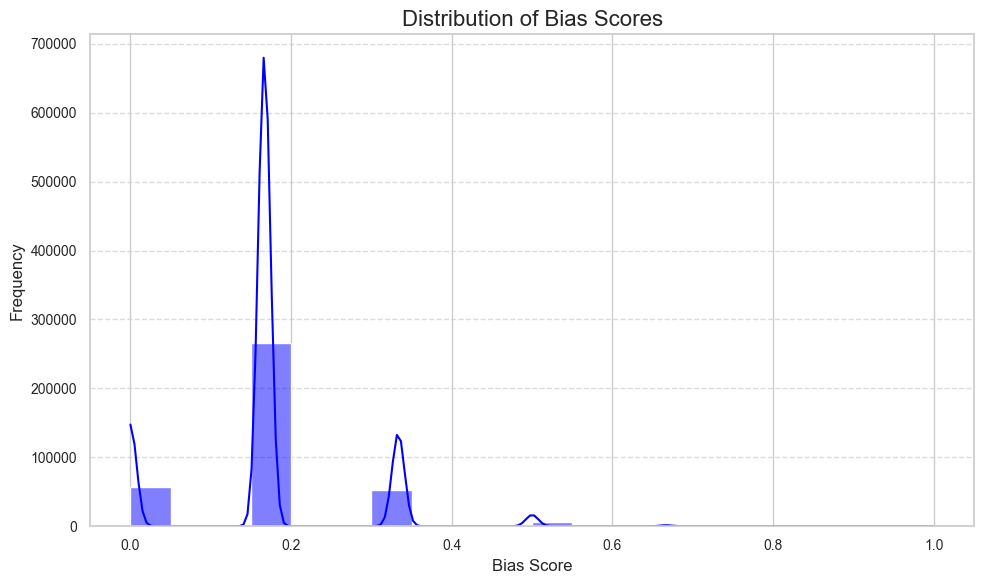

In [7]:
# Plotting bias distribution

# Setting Seaborn style
sns.set(style="whitegrid")

# Plotting histogram of 'bias'
plt.figure(figsize=(10, 6))
sns.histplot(headlines['bias'], bins=20, kde=True, color='blue')

# Styling the plot
plt.title('Distribution of Bias Scores', fontsize=16)
plt.xlabel('Bias Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Showing the plot
plt.tight_layout()
plt.show()

# Feature Engineering (for more EDA and Future Implementation) <a id='Feature_Engineering'></a>

In [8]:
# Creating feature 'sentiment_polarity'- scale of -1 to 1

# Creating a sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Applying the sentiment analyzer to each headline and storing the compound score - this takes a while to run
headlines['sentiment_polarity'] = headlines['headline_no_site'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [9]:
# Getting distribution of sentiment_polarity
headlines['sentiment_polarity'].value_counts()

sentiment_polarity
 0.0000    127683
-0.2960      6871
 0.4019      5231
-0.4767      4682
-0.3182      4423
            ...  
 0.6075         1
-0.4690         1
 0.5991         1
 0.7854         1
 0.4388         1
Name: count, Length: 4977, dtype: int64

In [10]:
# Printing min and max values for sentiment polarity
print(headlines['sentiment_polarity'].min())
print(headlines['sentiment_polarity'].max())

-0.979
0.9682


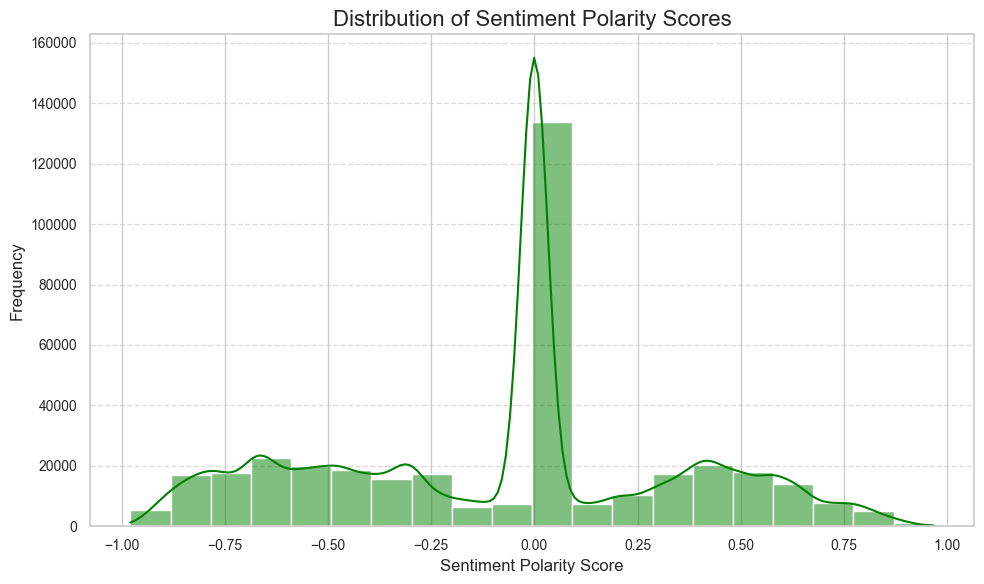

In [11]:
# Plotting dist of sentiment polarity

# Setting Seaborn style
sns.set(style="whitegrid")

# Plotting histogram of 'sentiment_polarity'
plt.figure(figsize=(10, 6))
sns.histplot(headlines['sentiment_polarity'], bins=20, kde=True, color='green')

# Styling the plot
plt.title('Distribution of Sentiment Polarity Scores', fontsize=16)
plt.xlabel('Sentiment Polarity Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Showing the plot
plt.tight_layout()
plt.show()

In [12]:
# Engineering 'Day of the Week' and 'Month' Features
headlines['Day_of_Week'] = pd.to_datetime(headlines['time']).dt.day_name()
headlines['Month'] = pd.to_datetime(headlines['time']).dt.month

# Engineering 'Hour of Dat' feature
headlines['Hour_of_Day'] = pd.to_datetime(headlines['time']).dt.hour

# Converting 'time' column to datetime format
headlines['time'] = pd.to_datetime(headlines['time'], errors='coerce')

# Extracting the year and creating a new 'Publication Year' feature
headlines['Publication_Year'] = headlines['time'].dt.year

In [13]:
# Dropping time column
headlines = headlines.drop(columns=['time'])

In [14]:
# Creating word count feature
headlines['Word_Count'] = headlines['headline_no_site'].apply(lambda x: len(x.split()))

# Creating text length feature
headlines['Text_Length'] = headlines['headline_no_site'].apply(len)

In [15]:
# Inspecting new head
headlines.head()

,headline_no_site,site,country,bias,sentiment_polarity,Day_of_Week,Month,Hour_of_Day,Publication_Year,Word_Count,Text_Length
0,'Lady Bird' buzzes through young sexuality,iol.co.za,South Africa,0.000000,0.0000,Friday,2,8,2018,6,42
1,The shadowy urban POP super Starrah who loves ...,iol.co.za,South Africa,0.166667,0.8225,Wednesday,1,8,2018,10,57
2,Rihanna pens heartfelt tribute to her mom in b...,iol.co.za,South Africa,0.333333,0.5423,Wednesday,2,8,2018,10,58
3,Shock as woman accused of killing teen girlfri...,iol.co.za,South Africa,0.333333,-0.7184,Tuesday,2,8,2018,11,65
4,TOP STORY: Meet South Africa's new first lady ...,iol.co.za,South Africa,0.166667,0.3680,Thursday,2,8,2018,10,62


In [16]:
# Getting value counts for site
headlines['site'].value_counts()

site
dailymail.co.uk    8219
telegraph.co.uk    7596
abcnews.go.com     6305
indiatimes.com     6269
mirror.co.uk       6207
                   ... 
news.google.com       4
makeuseof.com         3
howtogeek.com         3
pcadvisor.co.uk       1
dailysun.co.za        1
Name: count, Length: 186, dtype: int64

In [17]:
# Setting a threshold for news sites with at least 5000 headlines
min_headlines_threshold = 5000
top_sites = headlines['site'].value_counts()
top_sites = top_sites[top_sites >= min_headlines_threshold].index

# Creating a new dataframe with only the sites with at least 5000 headlines
headlines_filtered = headlines[headlines['site'].isin(top_sites)].copy()

In [18]:
# Getting value counts for country
headlines_filtered['country'].value_counts()

country
UK       42593
USA      39050
India    36306
Name: count, dtype: int64

/var/folders/xl/6sfvtvk54y1982txcc62tyqw0000gn/T/ipykernel_9723/1489788177.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='country', data=headlines_filtered, palette='viridis')


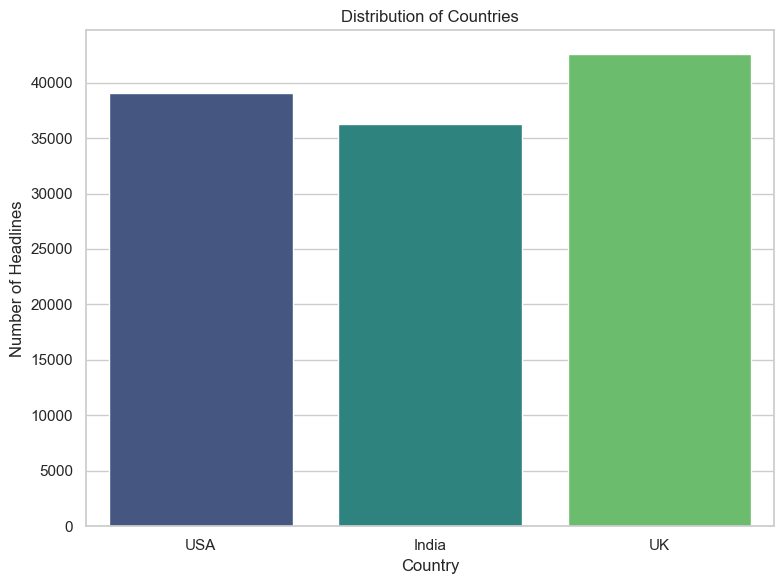

In [19]:
# Getting distribution of countries
plt.figure(figsize=(8, 6))
sns.countplot(x='country', data=headlines_filtered, palette='viridis')
plt.title('Distribution of Countries')
plt.xlabel('Country')
plt.ylabel('Number of Headlines')
plt.tight_layout()

# Showing the plot
plt.show()

In [20]:
# Filtering out all data for 'UK' and 'India' so that we stay in the US
headlines_filtered = headlines_filtered[headlines_filtered['country'].isin(['USA'])]

# Verify the changes
print(headlines_filtered['country'].value_counts())

country
USA    39050
Name: count, dtype: int64


In [21]:
# Getting shape of new DataFrame
headlines_filtered.shape

(39050, 11)

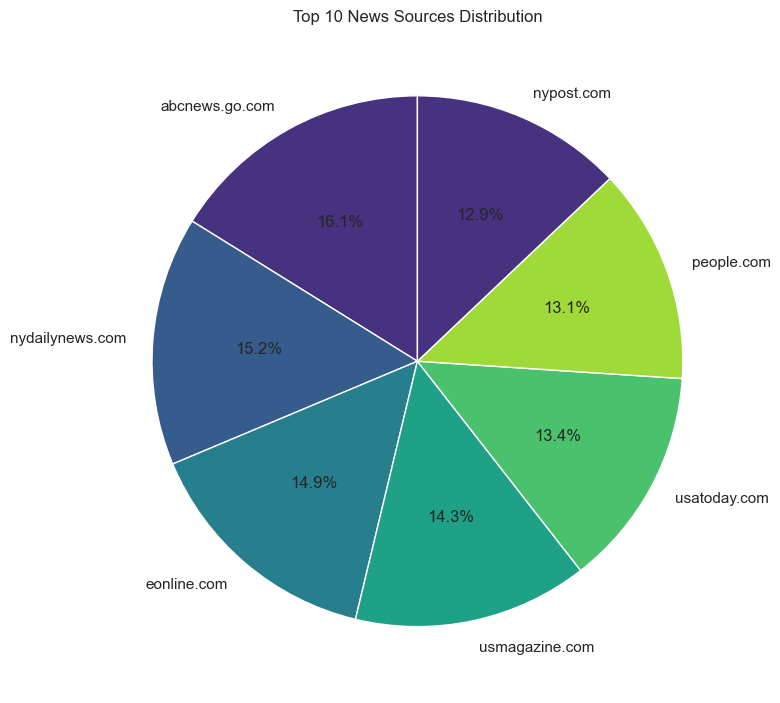

In [22]:
# Getting top 10 sites with most headlines
top_10_sites = headlines_filtered['site'].value_counts().nlargest(10)

# Creating a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_10_sites, labels=top_10_sites.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'), startangle=90)
plt.title('Top 10 News Sources Distribution')
plt.tight_layout()

# Showing the plot
plt.show()

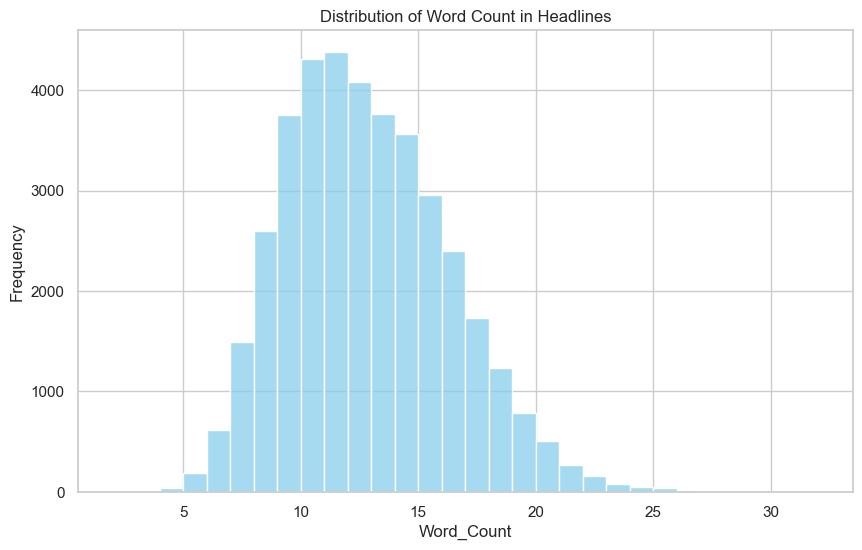

In [23]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(headlines_filtered['Word_Count'], bins=30, color='skyblue', kde=False)
plt.title('Distribution of Word Count in Headlines')
plt.xlabel('Word_Count')
plt.ylabel('Frequency')

# Show the plot
plt.show()

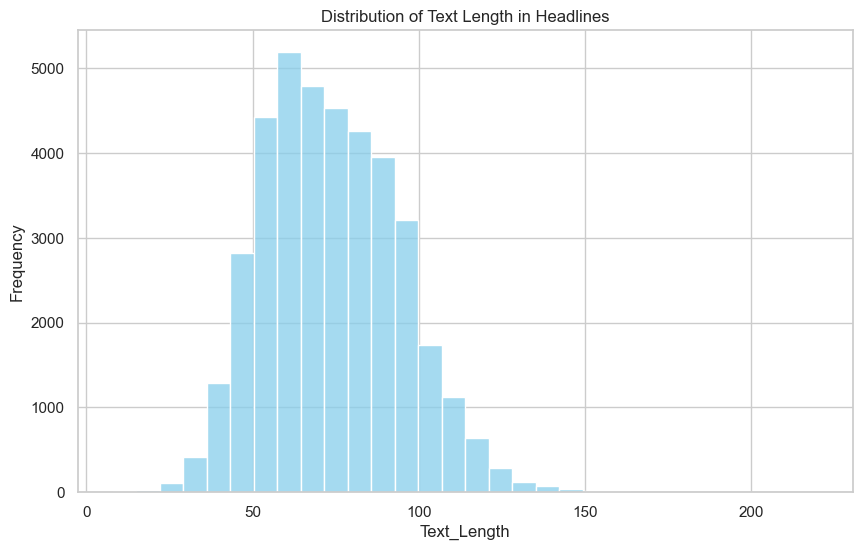

In [24]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(headlines_filtered['Text_Length'], bins=30, color='skyblue', kde=False)
plt.title('Distribution of Text Length in Headlines')
plt.xlabel('Text_Length')
plt.ylabel('Frequency')

# Show the plot
plt.show()

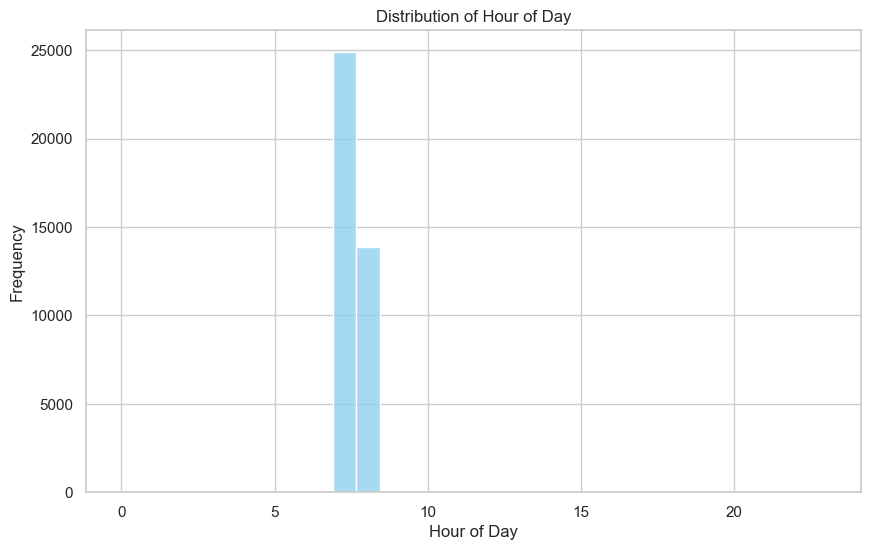

In [25]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(headlines_filtered['Hour_of_Day'], bins=30, color='skyblue', kde=False)
plt.title('Distribution of Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')

# Show the plot
plt.show()

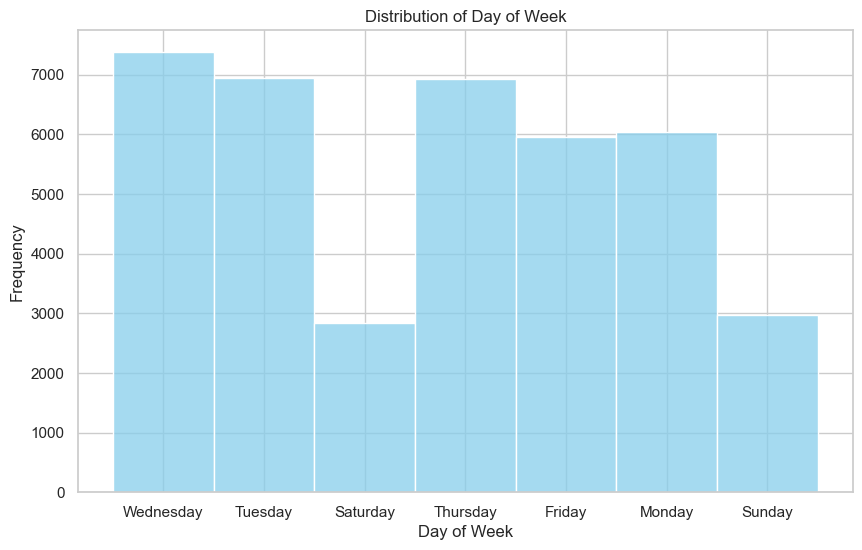

In [26]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(headlines_filtered['Day_of_Week'], bins=30, color='skyblue', kde=False)
plt.title('Distribution of Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [27]:
# Getting distribution of bias in headlines_filtered
headlines_filtered['bias'].value_counts()

bias
0.166667    26343
0.333333     6576
0.000000     5041
0.500000      982
0.666667      104
0.833333        4
Name: count, dtype: int64

In [28]:
# Setting values to drop
values_to_drop = [0.666667, 0.833333]

# Use boolean indexing to drop rows with specified values in 'bias' column
headlines_filtered = headlines_filtered[~headlines_filtered['bias'].isin(values_to_drop)]

In [29]:
# Defining conditions
conditions = [
    headlines_filtered['bias'].between(0.000000, 0.000000, inclusive='both'),
    headlines_filtered['bias'].between(0.1, 0.2, inclusive='both'),
    headlines_filtered['bias'].between(0.3, 0.5, inclusive='both'),
]

# Setting category labels
labels = ['No Bias', 'Low Bias', 'High Bias']

# Applying conditions
headlines_filtered['bias_category'] = np.select(conditions, labels, default=None)

In [30]:
# Getting unique bias category values
headlines_filtered['bias_category'].unique()

array(['High Bias', 'Low Bias', 'No Bias', None], dtype=object)

In [31]:
headlines_filtered['bias_category'].isnull().sum()

108

In [32]:
headlines_filtered = headlines_filtered.dropna()

In [33]:
headlines_filtered.isnull().sum()

headline_no_site      0
site                  0
country               0
bias                  0
sentiment_polarity    0
Day_of_Week           0
Month                 0
Hour_of_Day           0
Publication_Year      0
Word_Count            0
Text_Length           0
bias_category         0
dtype: int64

In [34]:
headlines_filtered['bias_category'].value_counts()

bias_category
Low Bias     26343
High Bias     7558
No Bias       5041
Name: count, dtype: int64

In [35]:
headlines_filtered.shape

(38942, 12)

In [36]:
# Dropping original bias column
headlines_filtered = headlines_filtered.drop(columns=['bias'])

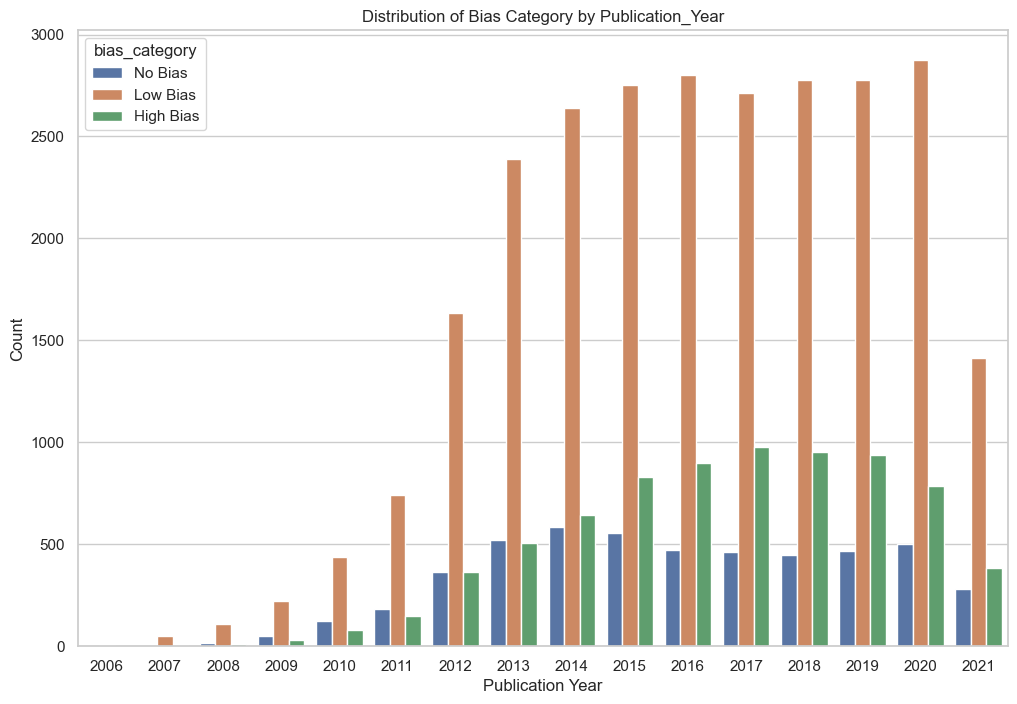

In [37]:
# Plotting the distribution of bias_category by Publication_Year

# Setting the style for seaborn
sns.set(style="whitegrid")

# Setting fig size, plotting feature interaction, setting axes titles and labels
plt.figure(figsize=(12, 8))
sns.countplot(x="Publication_Year", hue="bias_category", data=headlines_filtered)
plt.title('Distribution of Bias Category by Publication_Year')
plt.xlabel('Publication Year')
plt.ylabel('Count')

# Showing the plot
plt.show()

/var/folders/xl/6sfvtvk54y1982txcc62tyqw0000gn/T/ipykernel_9723/466765508.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violin = sns.violinplot(x='bias_category', y='sentiment_polarity', data=headlines_filtered, inner='quartile', palette='viridis')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


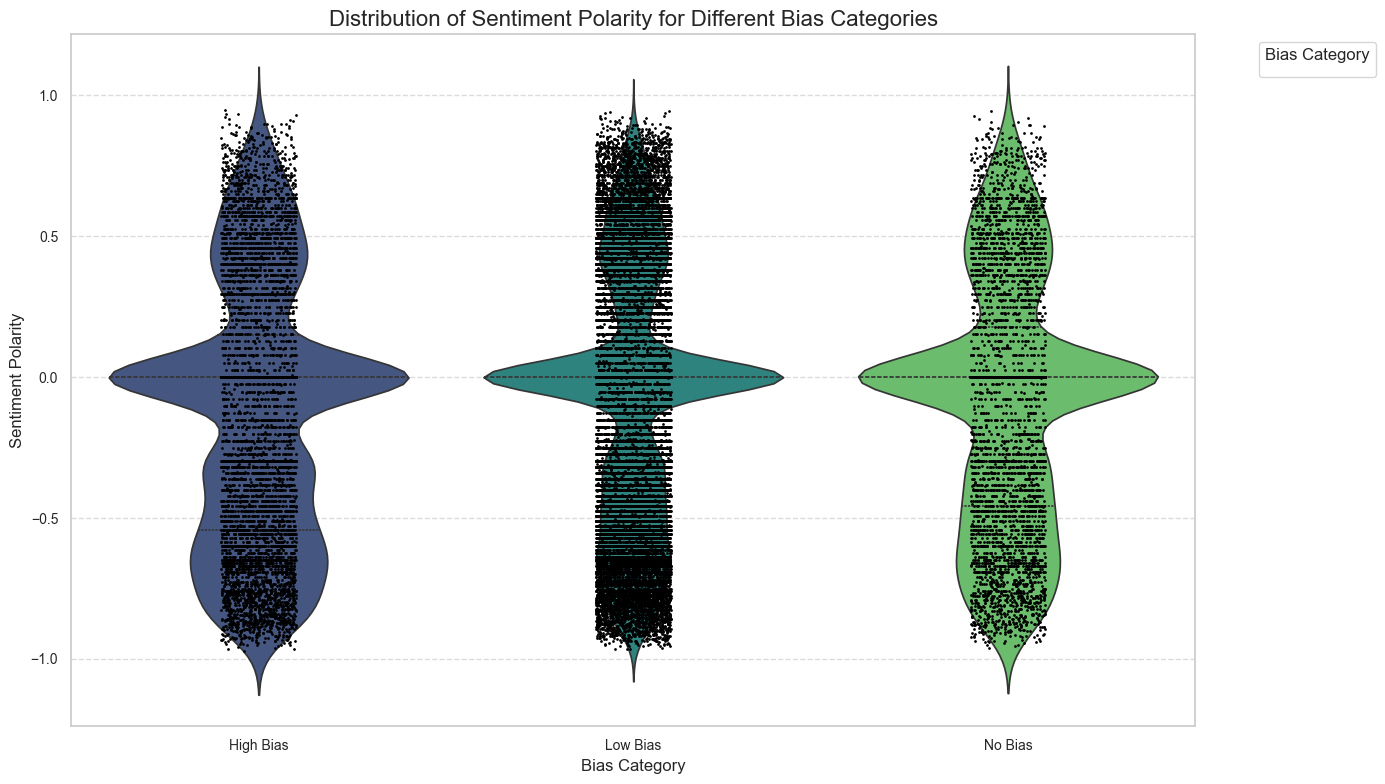

In [38]:
# Setting a Seaborn style
sns.set(style="whitegrid")

# Setting fig size, creating plot of feature interaction
plt.figure(figsize=(14, 8))

# Creating a violin plot with strip plot overlay
violin = sns.violinplot(x='bias_category', y='sentiment_polarity', data=headlines_filtered, inner='quartile', palette='viridis')
strip = sns.stripplot(x='bias_category', y='sentiment_polarity', data=headlines_filtered, color='black', size=2, jitter=True)

# Styling the plot
plt.title('Distribution of Sentiment Polarity for Different Bias Categories', fontsize=16)
plt.xlabel('Bias Category', fontsize=12)
plt.ylabel('Sentiment Polarity', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding a legend
plt.legend(title='Bias Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Showing the plot
plt.tight_layout()
plt.show()


In [39]:
# Renaming the 'headlines_no_site' column to 'headlines'
headlines_filtered.rename(columns={'headline_no_site': 'headlines'}, inplace=True)

headlines_filtered['headlines'].head()

9207           Mother and Daughter Reunite After 82 Years
9208    Hayden Panettiere 'Happy' to Stand Up for Wome...
9209    Woman Gets Trendy Tattoo to 'Caution' People S...
9210    Timeline of Alleged Abduction and Slaying of 1...
9211    Unabomber Ted Kaczynski's Brother, Sister in L...
Name: headlines, dtype: object

# Preprocessing<a id='Preprocessing'></a>

In [40]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
import gensim
import gensim.downloader
from gensim.utils import simple_preprocess

In [41]:
# Tokenize, Clean, and Lemmatize Text

# Tokenizing the headline text
headlines_filtered['tokenized_text'] = headlines_filtered['headlines'].apply(word_tokenize)

# Removing non-alphabetic characters, handle empty strings, and extra spaces
headlines_filtered['cleaned_text'] = headlines_filtered['tokenized_text'].apply(lambda tokens: [re.sub(r'[^a-zA-Z0-9]', '', token).strip() for token in tokens if re.sub(r'[^a-zA-Z0-9]', '', token).strip()])

# Converting to lowercase
headlines_filtered['cleaned_text'] = headlines_filtered['cleaned_text'].apply(lambda tokens: [token.lower() for token in tokens])

# Lemmatization - this takes a minute or two to run
lemmatizer = WordNetLemmatizer()
headlines_filtered['lemmatized_text'] = headlines_filtered['cleaned_text'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [42]:
# Storing a copy of headlines_filtered_encoded as lemmatized_df
lemmatized_df = headlines_filtered.copy()

In [43]:
# Dropping the 'headlines' column from lemmatized_df
lemmatized_df.drop('headlines', axis=1, inplace=True)

# Displaying the first row of lemmatized_df after dropping the column
lemmatized_df.head(1)

,site,country,sentiment_polarity,Day_of_Week,Month,Hour_of_Day,Publication_Year,Word_Count,Text_Length,bias_category,tokenized_text,cleaned_text,lemmatized_text
9207,abcnews.go.com,USA,0.0,Wednesday,2,8,2016,7,42,High Bias,"[Mother, and, Daughter, Reunite, After, 82, Ye...","[mother, and, daughter, reunite, after, 82, ye...","[mother, and, daughter, reunite, after, 82, year]"


In [44]:
# Getting stop words
stop_words = set(stopwords.words('english'))

# Creating no stopwords feature, removing stop words from the lemmatized_text column
lemmatized_df['lemmatized_text_no_stopwords'] = lemmatized_df['lemmatized_text'].apply(lambda tokens: [token for token in tokens if token not in stop_words])

In [45]:
# Inspecting head of lemmatized_text_no_stopwords feature
lemmatized_df['lemmatized_text_no_stopwords'].head()

9207                [mother, daughter, reunite, 82, year]
9208    [hayden, panettiere, happy, stand, woman, post...
9209    [woman, get, trendy, tattoo, caution, people, ...
9210    [timeline, alleged, abduction, slaying, 13, ye...
9211    [unabomber, ted, kaczynski, brother, sister, l...
Name: lemmatized_text_no_stopwords, dtype: object

In [46]:
# Storing a copy of lemmatized_df as df_to_vectorize
df_to_vectorize = lemmatized_df.copy()

In [47]:
# Setting list of columns to drop
columns_to_drop = ['tokenized_text', 'cleaned_text', 'lemmatized_text']

# Dropping the specified columns
df_to_vectorize.drop(columns=columns_to_drop, inplace=True)

In [48]:
# Inspecting head 
df_to_vectorize.head(1)

,site,country,sentiment_polarity,Day_of_Week,Month,Hour_of_Day,Publication_Year,Word_Count,Text_Length,bias_category,lemmatized_text_no_stopwords
9207,abcnews.go.com,USA,0.0,Wednesday,2,8,2016,7,42,High Bias,"[mother, daughter, reunite, 82, year]"


In [49]:
# Printing available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [50]:
# Downloading a pre-trained word embedding model and assigning it to 'model'- this will take a while! 
model = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [51]:
# Defining function
def text2vec(text):
    
    tokenized = text
    
    word_embeddings = [np.zeros(300)]
    for word in tokenized:
        if word in model:
            vector = model[word]
        else:
            vector = np.zeros(300)
            
        word_embeddings.append(vector)
    
    text_embedding = np.stack(word_embeddings).mean(axis=0)
    
    return text_embedding

In [52]:
# Applying the function over the lemmatized text column and assigning the results to new columns
df_to_vectorize['headline_vectors'] = df_to_vectorize['lemmatized_text_no_stopwords'].apply(lambda x: text2vec(x))

In [53]:
# Inspecting headline vectors
df_to_vectorize['headline_vectors'].head()

9207    [-0.010114432700599233, 0.02315941619842003, 0...
9208    [-0.018402375280857086, -0.012355675251455978,...
9209    [-0.012091000284999608, -0.0066915501840412615...
9210    [-0.005805909133050591, 0.009975600615143776, ...
9211    [-0.01995395952835679, -0.022855930007062854, ...
Name: headline_vectors, dtype: object

In [54]:
# Making copy of df_to_vectorize
final_df = df_to_vectorize.copy()

In [55]:
# Dropping the 'lemmatized_text_no_stopwords' column
final_df = final_df.drop('lemmatized_text_no_stopwords', axis=1)

In [56]:
# Checking headlines vectors of first row in filtered dataset
final_df['headline_vectors'][9207]

array([-1.01144327e-02,  2.31594162e-02,  3.38478331e-02, -2.61983400e-03,
        3.62601659e-02, -1.06493332e-02, -2.57916904e-04, -6.91277822e-02,
        3.44547993e-02, -3.27153669e-02,  2.43166648e-03,  2.58481659e-02,
        1.29131333e-02,  2.27498331e-02, -1.53669997e-02,  1.92172999e-02,
        2.11366670e-02, -2.11813335e-02,  1.02198500e-02,  3.86651834e-02,
       -6.10258337e-03, -4.23399964e-03, -5.46613497e-02,  8.27141653e-02,
        4.34007682e-02, -6.78025023e-03, -3.30020006e-03,  5.34819920e-03,
        2.84163666e-02,  1.97139827e-02,  7.35648190e-03,  1.29883364e-03,
       -2.31769999e-02, -4.24127669e-02, -1.95416656e-02, -4.42306713e-03,
       -3.61550009e-02, -4.07092326e-02,  1.79235004e-02, -1.36735667e-02,
       -6.36928327e-03, -4.02288832e-02,  1.82416600e-03, -3.50693002e-02,
        2.19708999e-02,  7.66333348e-02, -1.09447500e-02, -8.70424982e-03,
       -4.63549979e-03,  1.90033337e-02,  2.40958499e-02, -1.86153332e-02,
        6.97495028e-03,  

In [57]:
# Checking final_df for null values
final_df.isnull().sum()

site                  0
country               0
sentiment_polarity    0
Day_of_Week           0
Month                 0
Hour_of_Day           0
Publication_Year      0
Word_Count            0
Text_Length           0
bias_category         0
headline_vectors      0
dtype: int64

# Train Test Split<a id='Train_Test_Split'></a>

In [58]:
from sklearn.model_selection import train_test_split

In [61]:
# Setting X and y variables
X = final_df[['headline_vectors']]
y = final_df['bias_category']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (31153, 2)
y_train shape: (31153,)
X_test shape: (7789, 2)
y_test shape: (7789,)


In [62]:
# Ensuring there are no NaN values in y_train
y_train.unique()

array(['Low Bias', 'No Bias', 'High Bias'], dtype=object)

In [63]:
# Ensuring there are no NaN values in y_test
y_test.unique()

array(['High Bias', 'Low Bias', 'No Bias'], dtype=object)

In [65]:
# Converting X_train vectors to arrays- for later complex modeling
X_train_array = np.array(X_train['headline_vectors'].tolist())

# Converting X_test vectors to arrays
X_test_array = np.array(X_test['headline_vectors'].tolist())                           

In [66]:
X_train_array

array([[ 0.0118112 , -0.02826263,  0.03267959, ...,  0.00386307,
        -0.00758984, -0.00887941],
       [-0.01827431, -0.01129786,  0.05658613, ...,  0.02443756,
         0.01415028, -0.00603041],
       [-0.02869413, -0.00154161,  0.0110755 , ..., -0.01070486,
         0.03394732, -0.02429571],
       ...,
       [-0.0139151 , -0.01404694, -0.01344482, ..., -0.00026128,
        -0.00103142,  0.01009311],
       [ 0.01821074,  0.00642931,  0.0055661 , ...,  0.00886271,
         0.00948076, -0.01122147],
       [-0.005537  , -0.0081595 , -0.0094773 , ...,  0.01574317,
         0.02318462, -0.02449353]])

In [67]:
X_test_array

array([[-0.00622362,  0.00438962,  0.01905515, ...,  0.01767301,
         0.00946958, -0.00454697],
       [-0.00619883,  0.00523364,  0.01358382, ...,  0.01534192,
         0.02205315,  0.00835001],
       [ 0.00727306,  0.01166421,  0.00144094, ...,  0.0063027 ,
         0.00755804, -0.00780539],
       ...,
       [-0.02757343, -0.05089681, -0.01921928, ...,  0.02215261,
        -0.01848897, -0.00681179],
       [-0.00685749, -0.00837797,  0.00985022, ...,  0.01316061,
        -0.02753942, -0.00887434],
       [-0.00728046, -0.01582115,  0.00636818, ..., -0.00456625,
         0.0232201 ,  0.0174868 ]])

## Evaluation Metric: Weighted Average Precision<a id='Evaluation Metrics'></a>

By using the weighted average precision score, we aim to strike a balance between minimizing false positives, reducing false negatives, and accounting for the nuances in bias severity across all evaluated models. 

### Importance of Precision for Our Stakeholder

#### False Positives
- **Cost**: A false positive occurs when a headline is *incorrectly classified as having a bias that it does not possess.* For PBS, false positives can lead to inaccurate categorization for otherwise passable headlines, which we want to avoid.
- **Implication**: It is crucial to minimize false positives to maintain the credibility of PBS's ability to classify bias. Readers relying on these classifications should trust that the information accurately reflects the intended bias.

#### False Negatives
- **Cost**: A false negative occurs when a biased headline is *incorrectly classified as unbiased.* This might result in overlooking misleading information and passing off headlines that aren't fit to be published.
- **Implication**: Striking the right balance is essential to ensure readers are alerted to potential bias when it exists.

### Why Weighted Average Precision?

To comprehensively evaluate the performance of each model across all bias categories, we use the weighted average precision score as our primary evaluation metric, as it is *well suited to a class imbalance such as ours.*

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

## Logistic Regression

In [80]:
# Create a logistic regression model
logreg_model = LogisticRegression(max_iter=1000)

# Fit the model to the training data
logreg_model.fit(X_train_array, y_train)

LogisticRegression(max_iter=1000)

In [81]:
# Make predictions on the test set
logreg_y_pred = logreg_model.predict(X_test_array)

# Calculate the weighted-average precision score
logreg_weighted_precision = precision_score(y_test, logreg_y_pred, average='weighted')
print(f'LogReg Weighted Average Precision Score: {logreg_weighted_precision:.4f}')

LogReg Weighted Average Precision Score: 0.7213


In [82]:
# Generate confusion matrix
logreg_cm = confusion_matrix(y_test, logreg_y_pred)
logreg_cm

array([[ 282, 1205,    0],
       [ 152, 5092,    0],
       [  23, 1034,    1]])

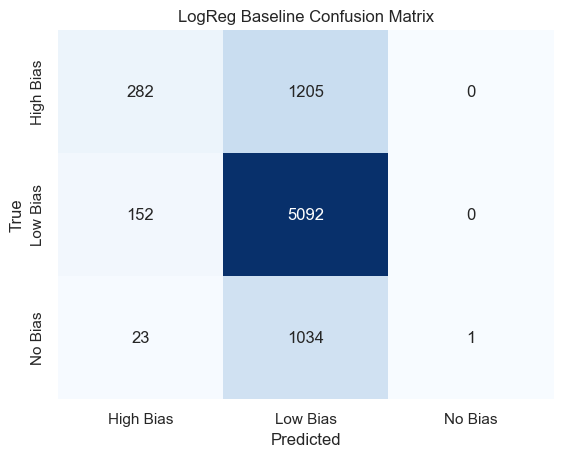

In [83]:
# Display the confusion matrix using a heatmap
sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=logreg_model.classes_, yticklabels=logreg_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [84]:
# Generate classification report
logreg_report = classification_report(y_test, logreg_y_pred)

# Print the classification report
print("Classification Report:\n", logreg_report)

Classification Report:
               precision    recall  f1-score   support

   High Bias       0.62      0.19      0.29      1487
    Low Bias       0.69      0.97      0.81      5244
     No Bias       1.00      0.00      0.00      1058

    accuracy                           0.69      7789
   macro avg       0.77      0.39      0.37      7789
weighted avg       0.72      0.69      0.60      7789



## Random Forest

In [85]:
# Specify the desired number of trees
num_trees = 50

# Create an instance of RandomForestClassifier with the specified number of trees
rf_model = RandomForestClassifier(n_estimators=num_trees, random_state=42)

# Train the model on the training data
rf_model.fit(X_train_array, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [86]:
# Make predictions on the test set
rf_y_pred = rf_model.predict(X_test_array)

# Calculate the weighted-average precision score
rf_weighted_precision = precision_score(y_test, rf_y_pred, average='weighted')
print(f'RF Weighted Average Precision Score: {rf_weighted_precision:.4f}')

RF Weighted Average Precision Score: 0.6215


In [87]:
# Generate classification report
rf_report = classification_report(y_test, rf_y_pred)

# Print the classification report
print("Classification Report:\n", rf_report)

Classification Report:
               precision    recall  f1-score   support

   High Bias       0.59      0.09      0.16      1487
    Low Bias       0.68      0.98      0.81      5244
     No Bias       0.36      0.00      0.01      1058

    accuracy                           0.68      7789
   macro avg       0.54      0.36      0.33      7789
weighted avg       0.62      0.68      0.57      7789



In [88]:
# Get unique classes from y_test
unique_classes = np.unique(y_test)

# Generate confusion matrix
rf_cm = confusion_matrix(y_test, rf_y_pred)
rf_cm

array([[ 140, 1347,    0],
       [  87, 5150,    7],
       [  11, 1043,    4]])

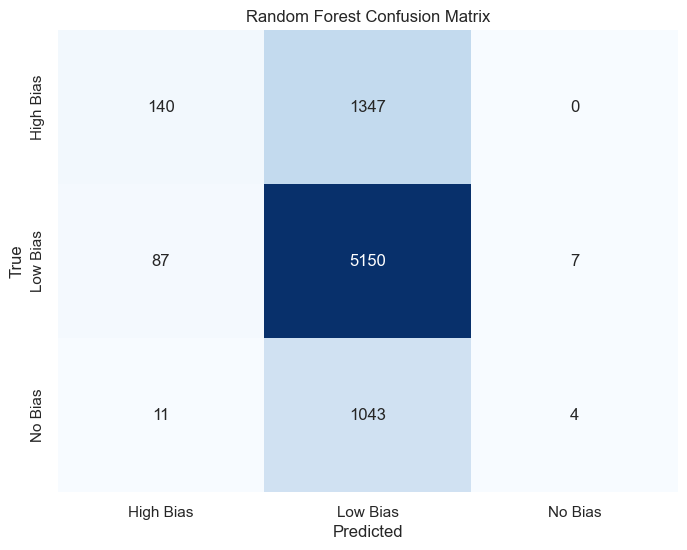

In [89]:
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()


# Support Vector Machine

In [90]:
from sklearn.svm import SVC

# Create an instance of Support Vector Machine (SVM) classifier
svm_model = SVC(random_state=42)

# Train the model on the training data
svm_model.fit(X_train_array, y_train)

# Make predictions on the test data
svm_y_pred = svm_model.predict(X_test_array)

In [91]:
# Calculate the weighted-average precision score
svm_weighted_precision = precision_score(y_test, svm_y_pred, average='weighted')
print(f'SVM Weighted Average Precision Score: {svm_weighted_precision:.4f}')

SVM Weighted Average Precision Score: 0.6079


/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
# Generate classification report
svm_report = classification_report(y_test, svm_y_pred)

# Print the classification report
print("Classification Report:\n", svm_report)

/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

   High Bias       0.73      0.18      0.29      1487
    Low Bias       0.70      0.98      0.81      5244
     No Bias       0.00      0.00      0.00      1058

    accuracy                           0.70      7789
   macro avg       0.48      0.39      0.37      7789
weighted avg       0.61      0.70      0.60      7789



/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
# Get unique classes from y_test
unique_classes = np.unique(y_test)

# Generate confusion matrix
svm_cm = confusion_matrix(y_test, svm_y_pred)
svm_cm

array([[ 269, 1218,    0],
       [  85, 5159,    0],
       [  13, 1045,    0]])

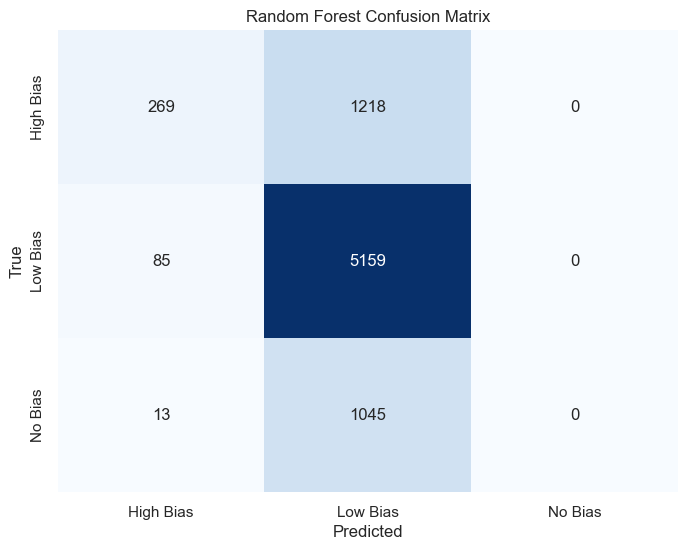

In [94]:
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Support Vector Machine Confusion Matrix')
plt.show()

# Neural Networks

In [95]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

2023-11-28 16:21:17.803886: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [96]:
# Assuming y_train is a pandas Series with string labels
label_encoder = LabelEncoder()

# Encoding y_test and y_train
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encoding y_train_encoded and y_test_encoded
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

# Assuming y_train_encoded is an array of class labels
class_labels = np.unique(y_train_encoded)

In [97]:
# Compute class weights for the neural network
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train_encoded)
class_weight_dict = dict(enumerate(class_weights))

### Baseline Neural Network

In [98]:
# Define the neural network model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train_array.shape[1], activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(len(class_labels), activation='softmax'))

# Compile the model with class weights
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
nn_model.fit(X_train_array, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

Epoch 1/10
779/779 [==============================] - 3s 3ms/step - loss: 1.0232 - accuracy: 0.4058 - val_loss: 0.9872 - val_accuracy: 0.4680
Epoch 2/10
779/779 [==============================] - 2s 3ms/step - loss: 0.9616 - accuracy: 0.4514 - val_loss: 1.0737 - val_accuracy: 0.3617
Epoch 3/10
779/779 [==============================] - 2s 2ms/step - loss: 0.9369 - accuracy: 0.4683 - val_loss: 0.9496 - val_accuracy: 0.5100
Epoch 4/10
779/779 [==============================] - 2s 2ms/step - loss: 0.9187 - accuracy: 0.4862 - val_loss: 0.9813 - val_accuracy: 0.4497
Epoch 5/10
779/779 [==============================] - 2s 2ms/step - loss: 0.9028 - accuracy: 0.4965 - val_loss: 0.9448 - val_accuracy: 0.5046
Epoch 6/10
779/779 [==============================] - 2s 2ms/step - loss: 0.8893 - accuracy: 0.5003 - val_loss: 0.9437 - val_accuracy: 0.5020
Epoch 7/10
779/779 [==============================] - 2s 2ms/step - loss: 0.8741 - accuracy: 0.5093 - val_loss: 0.9209 - val_accuracy: 0.5376
Epoch 

In [99]:
# Make predictions on the test data
nn_model_y_pred_one_hot = nn_model.predict(X_test_array)

# Convert the predicted probabilities to class labels
nn_model_y_pred_classes = np.argmax(nn_model_y_pred_one_hot, axis=1)

244/244 [==============================] - 0s 1ms/step


In [100]:
# Print classification report for baseline neural network
print(classification_report(y_test_encoded, nn_model_y_pred_classes, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

   High Bias       0.42      0.60      0.50      1487
    Low Bias       0.80      0.35      0.49      5244
     No Bias       0.21      0.68      0.32      1058

    accuracy                           0.44      7789
   macro avg       0.48      0.54      0.44      7789
weighted avg       0.65      0.44      0.47      7789



### Neural Network with Dropout Rate

In [101]:
# Define the neural network model
nn_model_2 = Sequential()
nn_model_2.add(Dense(64, input_dim=X_train_array.shape[1], activation='relu'))
nn_model_2.add(Dropout(0.5))  # Adding dropout rate of 0.5
nn_model_2.add(Dense(32, activation='relu'))
nn_model_2.add(Dropout(0.5))  # Adding dropout rate of 0.5
nn_model_2.add(Dense(len(class_labels), activation='softmax'))

# Compile the model with class weights
nn_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
nn_model_2.fit(X_train_array, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

Epoch 1/10
779/779 [==============================] - 3s 3ms/step - loss: 1.0736 - accuracy: 0.3559 - val_loss: 1.0429 - val_accuracy: 0.3574
Epoch 2/10
779/779 [==============================] - 2s 3ms/step - loss: 1.0253 - accuracy: 0.3365 - val_loss: 1.0070 - val_accuracy: 0.3786
Epoch 3/10
779/779 [==============================] - 2s 3ms/step - loss: 1.0048 - accuracy: 0.3717 - val_loss: 0.9991 - val_accuracy: 0.4519
Epoch 4/10
779/779 [==============================] - 2s 3ms/step - loss: 0.9851 - accuracy: 0.4085 - val_loss: 0.9926 - val_accuracy: 0.4296
Epoch 5/10
779/779 [==============================] - 2s 3ms/step - loss: 0.9733 - accuracy: 0.4116 - val_loss: 0.9679 - val_accuracy: 0.4524
Epoch 6/10
779/779 [==============================] - 2s 3ms/step - loss: 0.9673 - accuracy: 0.4291 - val_loss: 0.9574 - val_accuracy: 0.4922
Epoch 7/10
779/779 [==============================] - 2s 3ms/step - loss: 0.9551 - accuracy: 0.4374 - val_loss: 0.9634 - val_accuracy: 0.4685
Epoch 

In [105]:
# Make predictions on the test data
nn_model_2_y_pred_one_hot = nn_model_2.predict(X_test_array)

# Convert the predicted probabilities to class labels
nn_model_2_y_pred_classes = np.argmax(nn_model_2_y_pred_one_hot, axis=1)

244/244 [==============================] - 0s 1ms/step


In [106]:
# Print classification report
print(classification_report(y_test_encoded, nn_model_2_y_pred_classes, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

   High Bias       0.36      0.72      0.48      1487
    Low Bias       0.78      0.43      0.56      5244
     No Bias       0.25      0.45      0.32      1058

    accuracy                           0.49      7789
   macro avg       0.46      0.53      0.45      7789
weighted avg       0.63      0.49      0.51      7789



# Complex Models

## Neural Networks

### Neural Network with L2 Regularization

In [107]:
# Define the simple neural network model
nn_model_3 = Sequential()
nn_model_3.add(Dense(64, input_dim=X_train_array.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
nn_model_3.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
nn_model_3.add(Dense(len(class_labels), activation='softmax'))

# Compile the model with class weights
nn_model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
nn_model_3.fit(X_train_array, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

Epoch 1/10
779/779 [==============================] - 3s 3ms/step - loss: 1.1912 - accuracy: 0.2733 - val_loss: 1.0991 - val_accuracy: 0.1286
Epoch 2/10
779/779 [==============================] - 2s 3ms/step - loss: 1.0968 - accuracy: 0.4702 - val_loss: 1.1015 - val_accuracy: 0.1286
Epoch 3/10
779/779 [==============================] - 2s 2ms/step - loss: 1.0969 - accuracy: 0.2779 - val_loss: 1.0980 - val_accuracy: 0.1286
Epoch 4/10
779/779 [==============================] - 2s 2ms/step - loss: 1.0968 - accuracy: 0.1701 - val_loss: 1.0937 - val_accuracy: 0.6721
Epoch 5/10
779/779 [==============================] - 2s 2ms/step - loss: 1.0968 - accuracy: 0.5775 - val_loss: 1.1026 - val_accuracy: 0.1286
Epoch 6/10
779/779 [==============================] - 2s 3ms/step - loss: 1.0968 - accuracy: 0.4661 - val_loss: 1.1033 - val_accuracy: 0.1286
Epoch 7/10
779/779 [==============================] - 2s 3ms/step - loss: 1.0968 - accuracy: 0.3561 - val_loss: 1.0956 - val_accuracy: 0.6721
Epoch 

In [108]:
# Make predictions on the test data
nn_model_3_y_pred_one_hot = nn_model_3.predict(X_test_array)

# Convert the predicted probabilities to class labels
nn_model_3_y_pred_classes = np.argmax(nn_model_3_y_pred_one_hot, axis=1)

# Print classification report
print(classification_report(y_test_encoded, nn_model_3_y_pred_classes, target_names=label_encoder.classes_))

244/244 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

   High Bias       0.00      0.00      0.00      1487
    Low Bias       0.00      0.00      0.00      5244
     No Bias       0.14      1.00      0.24      1058

    accuracy                           0.14      7789
   macro avg       0.05      0.33      0.08      7789
weighted avg       0.02      0.14      0.03      7789



/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Neural Network with Batch Normalization

In [109]:
# Define the neural network model
nn_model_4 = Sequential()
nn_model_4.add(Dense(64, input_dim=X_train_array.shape[1], activation='relu'))
nn_model_4.add(BatchNormalization())
nn_model_4.add(Dense(32, activation='relu'))
nn_model_4.add(BatchNormalization())
nn_model_4.add(Dense(len(class_labels), activation='softmax'))

# Compile the model with class weights
nn_model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
nn_model_4.fit(X_train_array, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)


Epoch 1/10
779/779 [==============================] - 4s 3ms/step - loss: 1.0324 - accuracy: 0.4342 - val_loss: 1.0728 - val_accuracy: 0.4089
Epoch 2/10
779/779 [==============================] - 2s 3ms/step - loss: 0.9396 - accuracy: 0.4870 - val_loss: 1.0081 - val_accuracy: 0.4715
Epoch 3/10
779/779 [==============================] - 2s 2ms/step - loss: 0.9113 - accuracy: 0.5008 - val_loss: 0.9818 - val_accuracy: 0.4905
Epoch 4/10
779/779 [==============================] - 2s 2ms/step - loss: 0.8943 - accuracy: 0.5113 - val_loss: 0.9630 - val_accuracy: 0.5147
Epoch 5/10
779/779 [==============================] - 2s 3ms/step - loss: 0.8766 - accuracy: 0.5213 - val_loss: 0.9799 - val_accuracy: 0.4776
Epoch 6/10
779/779 [==============================] - 2s 3ms/step - loss: 0.8553 - accuracy: 0.5337 - val_loss: 0.9429 - val_accuracy: 0.5280
Epoch 7/10
779/779 [==============================] - 2s 3ms/step - loss: 0.8390 - accuracy: 0.5400 - val_loss: 0.9870 - val_accuracy: 0.4913
Epoch 

In [110]:
# Make predictions on the test data
nn_model_4_y_pred_one_hot = nn_model_4.predict(X_test_array)

# Convert the predicted probabilities to class labels
nn_model_4_y_pred_classes = np.argmax(nn_model_4_y_pred_one_hot, axis=1)

244/244 [==============================] - 0s 1ms/step


In [111]:
# Print classification report
print(classification_report(y_test_encoded, nn_model_4_y_pred_classes, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

   High Bias       0.36      0.71      0.48      1487
    Low Bias       0.80      0.43      0.56      5244
     No Bias       0.23      0.45      0.31      1058

    accuracy                           0.49      7789
   macro avg       0.46      0.53      0.45      7789
weighted avg       0.64      0.49      0.51      7789



### Neural Network with Added Layer

In [112]:
# Define the neural network model
nn_model_5 = Sequential()
nn_model_5.add(Dense(128, input_dim=X_train_array.shape[1], activation='relu'))
nn_model_5.add(BatchNormalization())
nn_model_5.add(Dense(64, input_dim=X_train_array.shape[1], activation='relu'))
nn_model_5.add(BatchNormalization())
nn_model_5.add(Dense(32, activation='relu'))
nn_model_5.add(BatchNormalization())
nn_model_5.add(Dense(len(class_labels), activation='softmax'))

# Compile the model with class weights
nn_model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
nn_model_5.fit(X_train_array, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

Epoch 1/10
779/779 [==============================] - 4s 3ms/step - loss: 1.0453 - accuracy: 0.4253 - val_loss: 1.1192 - val_accuracy: 0.3678
Epoch 2/10
779/779 [==============================] - 3s 4ms/step - loss: 0.9387 - accuracy: 0.4789 - val_loss: 1.0212 - val_accuracy: 0.4447
Epoch 3/10
779/779 [==============================] - 3s 4ms/step - loss: 0.9042 - accuracy: 0.5002 - val_loss: 1.1457 - val_accuracy: 0.3693
Epoch 4/10
779/779 [==============================] - 2s 3ms/step - loss: 0.8794 - accuracy: 0.5183 - val_loss: 0.9504 - val_accuracy: 0.5240
Epoch 5/10
779/779 [==============================] - 3s 4ms/step - loss: 0.8591 - accuracy: 0.5244 - val_loss: 0.9403 - val_accuracy: 0.5193
Epoch 6/10
779/779 [==============================] - 2s 3ms/step - loss: 0.8311 - accuracy: 0.5452 - val_loss: 1.0275 - val_accuracy: 0.4429
Epoch 7/10
779/779 [==============================] - 2s 3ms/step - loss: 0.8184 - accuracy: 0.5453 - val_loss: 0.9838 - val_accuracy: 0.5020
Epoch 

In [114]:
# Make predictions on the test data
nn_model_5_y_pred_one_hot = nn_model_5.predict(X_test_array)

# Convert the predicted probabilities to class labels
nn_model_5_y_pred_classes = np.argmax(nn_model_5_y_pred_one_hot, axis=1)

244/244 [==============================] - 0s 1ms/step


In [115]:
# Print classification report
print(classification_report(y_test_encoded, nn_model_5_y_pred_classes, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

   High Bias       0.40      0.58      0.48      1487
    Low Bias       0.75      0.45      0.56      5244
     No Bias       0.21      0.50      0.29      1058

    accuracy                           0.48      7789
   macro avg       0.45      0.51      0.44      7789
weighted avg       0.61      0.48      0.51      7789



## Long Short-Term Memory (LSTM) Recurrent Neural Network

In [116]:
from tensorflow.keras.layers import LSTM

In [117]:
# Define the neural network model with LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_array.shape[1], 1), activation='relu'))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(len(class_labels), activation='softmax'))

# Compile the model with class weights and a faster learning rate
lstm_model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape the input data for LSTM (assuming X_train_array has shape (samples, features))
X_train_reshaped = X_train_array.reshape((X_train_array.shape[0], X_train_array.shape[1], 1))

# Train the RNN model with class weights
lstm_model.fit(X_train_reshaped, y_train_one_hot, epochs=5, batch_size=250, validation_split=0.2, class_weight=class_weight_dict)

Epoch 1/5
100/100 [==============================] - 48s 453ms/step - loss: 1.1055 - accuracy: 0.3717 - val_loss: 1.1097 - val_accuracy: 0.1286
Epoch 2/5
100/100 [==============================] - 47s 464ms/step - loss: 1.0979 - accuracy: 0.3565 - val_loss: 1.0823 - val_accuracy: 0.6721
Epoch 3/5
100/100 [==============================] - 51s 512ms/step - loss: 1.0974 - accuracy: 0.3521 - val_loss: 1.0883 - val_accuracy: 0.6721
Epoch 4/5
100/100 [==============================] - 45s 449ms/step - loss: 1.0971 - accuracy: 0.3356 - val_loss: 1.0965 - val_accuracy: 0.1993
Epoch 5/5
100/100 [==============================] - 41s 405ms/step - loss: 1.0974 - accuracy: 0.3127 - val_loss: 1.0921 - val_accuracy: 0.1286


In [118]:
# Make predictions on the test data
lstm_model_y_pred_one_hot = lstm_model.predict(X_test_array)

# Convert the predicted probabilities to class labels
lstm_model_y_pred_classes = np.argmax(lstm_model_y_pred_one_hot, axis=1)

# Convert true labels to class labels
lstm_model_y_test_classes = np.argmax(y_test_one_hot, axis=1)

244/244 [==============================] - 7s 28ms/step


In [119]:
# Print classification report
print(classification_report(lstm_model_y_test_classes, lstm_model_y_pred_classes, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

   High Bias       0.00      0.00      0.00      1487
    Low Bias       0.00      0.00      0.00      5244
     No Bias       0.14      1.00      0.24      1058

    accuracy                           0.14      7789
   macro avg       0.05      0.33      0.08      7789
weighted avg       0.02      0.14      0.03      7789



/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Recommendations

FairFrame: A Bias Mitigation Tool for Writers and Editors

PBS needs to back up its reputation as an objective American news sourse and defend itself against adversarial actors threatening to defund it on accusations of bias. In order to achieve this, we propose FairFrame - simple standalone app or a browser extension — for writers and editors at PBS. This tool aims to assist in identifying and mitigating potential biases in headlines throughout the editorial process.

- **Headline Input:** Users can feed headlines into the tool for analysis.
- **Bias Categorization:** The tool employs a pretrained model to categorize the bias of the content into different levels (e.g., High Bias, Moderate Bias, Neutral).
- **Guided Editing Notes:** For content flagged with bias, the tool's various pre-loaded functions provide users with actionable and specific editing suggestions. For instance: "Consider neutralizing language in this sentence." OR "Use active voice for greater clarity and objectivity." OR "Adjust the tone to ensure a balanced representation."
- **User-Friendly Interface:** The tool features an intuitive and user-friendly interface, ensuring seamless integration into the editorial workflow.
- **Benefits:** The tool has the potential enhance objectivity, empower writers and editors, hold all writers and editors to consistent standards, and promote efficient editing.

**Implementation**:
- Collaborate with machine learning experts to fine-tune the bias categorization model based on PBS's editorial guidelines.
Conduct thorough training sessions for writers and editors to ensure effective utilization of the tool.
    
**Additional Recommendations:**
- Publish each article's headline bias score in plain view for readers to see
- Advertise and demonstrate the use and efficacy of FairFrame in public funding defense efforts

# Further Inquiry

- **Invest in including some or all features engineered throughout our Feature Engineering (and more EDA) section.** We tried running comprehensive models using one or more of the engineered features, both one-hot-encoded categorical features and numerical featues. It caused our models to run very slowly and in the interest of time and the scope of our project, we decided to leave it up to PBS to prepare and include them in future model iterations.

- **Utilize the SMOTE library or a variant of it to address class imbalance head on.** These librares generate synthetic examples of the minority class to create a more balanced distribution and could lead to better optimized models.

- **Invest in collecting or utilizing existing PBS-specific headline data** to increase the relevance and efficacy of FairFrame.

- **Continue to test neural networks** by adding or subtracting layers, activation functions like LeakyReLU, and experimenting with different batch sizes and number of epochs.